## Time to get your hands dirty! Fun with Gamma Ray Bursts
Let's look at the latest database of Gamma Ray Bursts.

 - The database can be downloaded at https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt
 - You can find the physical meaning of each variable at https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html 


This edition of "get your hands dirty" is very open ended (we're getting closer and closer to real research...). You have a cool dataset, explore it! Play with the data, apply some of the tecniques we have seen in classes so far, etc. **Be creative! You're discovering**


Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers?
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed? 


In [1]:
import numpy as np
from matplotlib import pyplot as plt
import requests
from astropy.visualization.hist import hist as fancyhist
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import MeanShift
from sklearn import preprocessing
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix
import scipy.stats as stats

GRB are extremely energetic explosion observed in distant galaxies. They originates from Supernova explosion or from Neutron Star Mergers.
It's well known in literature the distinction between short GRB and long GRB. The first ones last for less than 2s an they are the 30% of the total GRB observed. The second category contains the remnant case.

In [2]:
# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

print(names)

['GRB_name' 'GRB_name_Fermi' 'T0' 'ra' 'decl' 'pos_error' 'T90'
 'T90_error' 'T90_start' 'fluence' 'fluence_error' 'redshift' "'T100'"
 'GBM_located' 'mjd_(T0)']


In [3]:
T90 = np.array(data[6],dtype=float)  #Duration of the time interval during which 90% of the GRB photon counts are observed (From 5% to 95%)
fluence = np.array(data[9],dtype=float)  #The time integrated total energy per unit surface

#Considering only positive values since whene there are missing or problematice observation the catalog puts the values equal to -999
logT90 = np.log10(T90[(T90>0) & (fluence>0)])
logfluence = np.log10(fluence[(T90>0) & (fluence>0)])

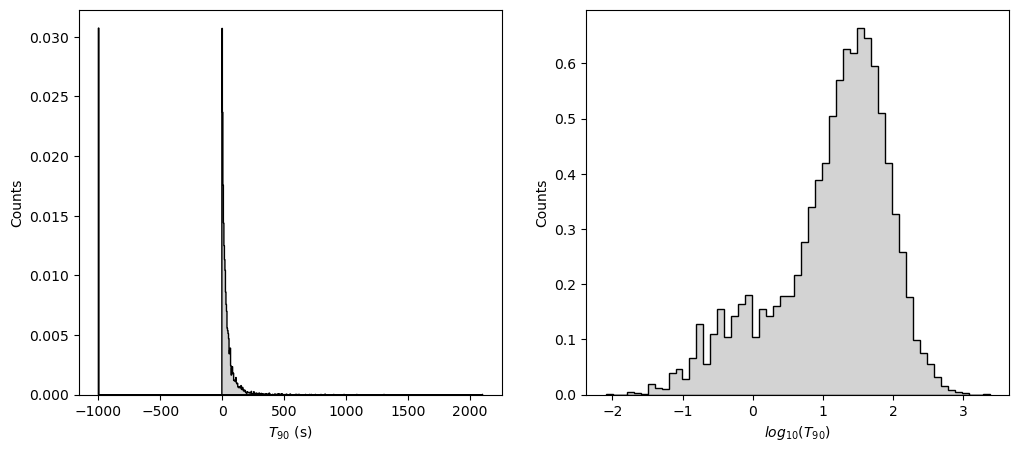

In [4]:
#Histogram of log(T90)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

fancyhist(T90, bins="freedman", ax=axs[0], density=True, ec='black', fc='lightgrey', histtype='stepfilled')
axs[0].set_xlabel(r'$T_{90}$ (s)')
axs[0].set_ylabel('Counts')


fancyhist(logT90, bins="freedman", ax=axs[1], density=True, ec='black', fc='lightgrey', histtype='stepfilled')
axs[1].set_xlabel(r'$log_{10}(T_{90})$')
axs[1].set_ylabel('Counts')

plt.show()

It seems like there are two modes in the distribution of log(T90).

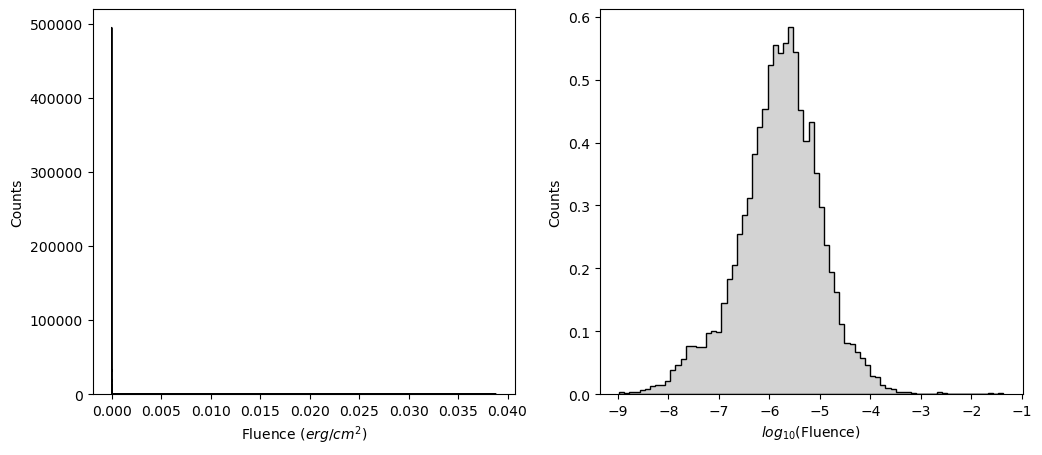

In [5]:
#Histogram of log(Fluence)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

fancyhist(fluence[fluence > 0], bins="freedman", ax=axs[0], density=True, ec='black', fc='lightgrey', histtype='stepfilled')
axs[0].set_xlabel(r'Fluence $(erg/cm^2)$')
axs[0].set_ylabel('Counts')

fancyhist(logfluence, bins="freedman", ax=axs[1], density=True, ec='black', fc='lightgrey', histtype='stepfilled')
axs[1].set_xlabel(r'$log_{10}$(Fluence)')
axs[1].set_ylabel('Counts')

plt.show()

## KDE

In [6]:
#Defining the function to perform KDE
def kde_sklearn(data, grid, bandwidth = 1.0, kernel = "linear"):
    kde_skl = KernelDensity(bandwidth = bandwidth, kernel = kernel)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(grid[:, np.newaxis])
    return np.exp(log_pdf)

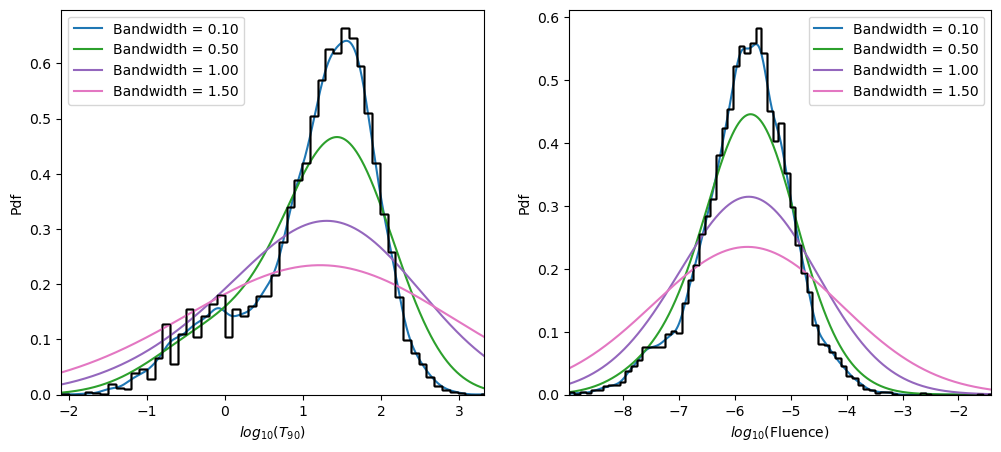

In [7]:
#Performing KDE on log(T90) and log(Fluence) trying different bandwidths selected manually
Tgrid = np.linspace(logT90.min(), logT90.max(), 10000) 
Fgrid = np.linspace(logfluence.min(), logfluence.max(), 10000) 
bandwidth = [0.1, 0.5, 1, 1.5]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
for b in bandwidth:
    pdf_T90 = kde_sklearn(logT90, Tgrid, bandwidth = b, kernel = 'gaussian') 
    axs[0].plot(Tgrid, pdf_T90, label = 'Bandwidth = %0.2f' %(b)) 
    fancyhist(logT90, bins="freedman", density=True, ax=axs[0], ec='black', histtype='step')
    axs[0].set_xlim(logT90.min(), logT90.max())
    axs[0].set_xlabel(r'$log_{10}(T_{90})$')
    axs[0].set_ylabel('Pdf')
    axs[0].legend(loc='upper left')
    
    pdf_fluence = kde_sklearn(logfluence, Fgrid, bandwidth = b, kernel = 'gaussian') 
    axs[1].plot(Fgrid, pdf_fluence, label = 'Bandwidth = %0.2f' %(b)) 
    fancyhist(logfluence, bins="freedman", density=True, ax=axs[1], ec='black', histtype='step')
    axs[1].set_xlim(logfluence.min(), logfluence.max())
    axs[1].set_xlabel(r'$log_{10}$(Fluence)')
    axs[1].set_ylabel('Pdf')
    axs[1].legend(loc='upper right')

plt.show()

In [8]:
#Defining the cross validation function used to find the optimal bandwidth
def cross(data):
    grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv= K)
    grid.fit(data[:, None])
    return grid.best_params_['bandwidth']

In [9]:
#Performing the cross validation on log(T90) and log(Fluence)
bwrange = np.linspace(0.05, 0.5, 50)
K = 5
bw_T90 = cross(logT90)
bw_fluence = cross(logfluence)

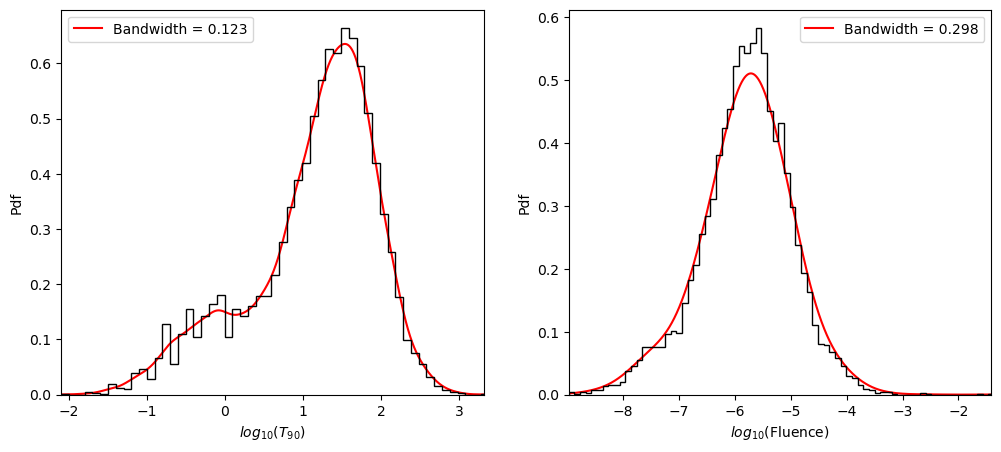

In [10]:
#Performing KDE with the optimal bandwidths
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

pdf_T90 = kde_sklearn(logT90, Tgrid, bandwidth = bw_T90, kernel = 'gaussian') 
axs[0].plot(Tgrid, pdf_T90, label = 'Bandwidth = %0.3f' %(bw_T90), color = 'red') 
fancyhist(logT90, bins="freedman", density=True, ax=axs[0], ec='black', histtype='step')
axs[0].set_xlim(logT90.min(), logT90.max())
axs[0].set_xlabel(r'$log_{10}(T_{90})$')
axs[0].set_ylabel('Pdf')
axs[0].legend(loc='upper left')

pdf_fluence = kde_sklearn(logfluence, Fgrid, bandwidth = bw_fluence, kernel = 'gaussian') 
axs[1].plot(Fgrid, pdf_fluence, label = 'Bandwidth = %0.3f' %(bw_fluence), color = 'red') 
fancyhist(logfluence, bins="freedman", density=True, ax=axs[1], ec='black', histtype='step')
axs[1].set_xlim(logfluence.min(), logfluence.max())
axs[1].set_xlabel(r'$log_{10}$(Fluence)')
axs[1].set_ylabel('Pdf')
axs[1].legend(loc='upper right')

plt.show()

It is more clear that there are two modes in the distribution of log(T90). In the case of log(Fluence) we cannot see the two modes.

## Clustering

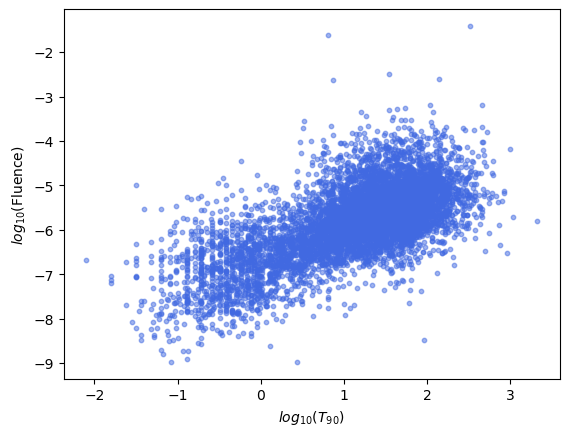

In [11]:
#Scatter plot of log(T90) vs log(Fluence)
plt.scatter(logT90, logfluence, s = 10, color = 'royalblue', alpha = 0.5)
plt.xlabel(r'$log_{10}(T_{90})$')
plt.ylabel(r'$log_{10}$(Fluence)')
plt.show()

In [12]:
X = np.stack([logT90, logfluence], axis=1)

In [13]:
#Standardizing the data
scaler = preprocessing.StandardScaler()
Y = scaler.fit_transform(X)

#### K-Means

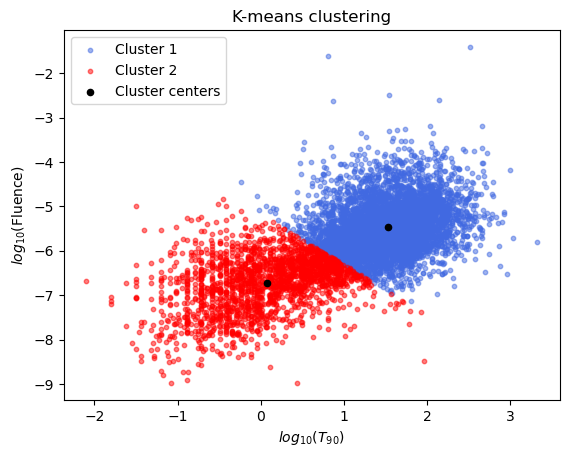

In [14]:
kmean = KMeans(n_clusters=2)  #Defining the Kmeans estimator object. In our case we search for 2 clusters
kmean.fit(Y)  #Fitting the data
centers_k = scaler.inverse_transform(kmean.cluster_centers_)  #Computing the location of the cluster centers
labels_k = kmean.predict(Y)  #Predicting the labels for each of the points

#Plotting the results
colors = ['royalblue', 'red']
for ii in range(2):
    plt.scatter(X[labels_k==ii,0], X[labels_k==ii,1], color=colors[ii] ,alpha=0.5, s=10, label='Cluster %i' %(ii+1))

plt.xlabel(r'$log_{10}(T_{90})$')
plt.ylabel(r'$log_{10}$(Fluence)')
plt.title('K-means clustering')
plt.scatter(centers_k[:,0],centers_k[:,1], color='black', s=20, label = 'Cluster centers')
plt.legend()
plt.show()

In [15]:
#Printing the values of the cluster centers
print('Cluster 1:')
print('T90 = %f s' %(10**(centers_k[0,0])))
print('Fluence = 10^(%f) erg/cm^2\n' %((centers_k[0,1])))
print('Cluster 2:')
print('T90 = %f s' %(10**(centers_k[1,0])))
print('Fluence = 10^(%f) erg/cm^2' %((centers_k[1,1])))

Cluster 1:
T90 = 33.776159 s
Fluence = 10^(-5.456111) erg/cm^2

Cluster 2:
T90 = 1.193725 s
Fluence = 10^(-6.718535) erg/cm^2


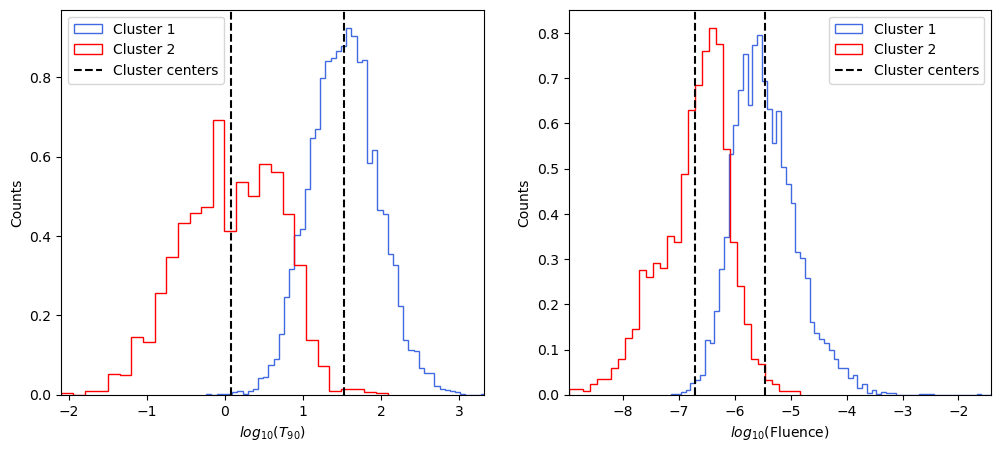

In [16]:
#Histogram of each singular clusters
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

fancyhist(X[labels_k==0,0], bins="freedman", density=True, ax=axs[0], ec='royalblue', histtype='step', label='Cluster 1')
fancyhist(X[labels_k==1,0], bins="freedman", density=True, ax=axs[0], ec='red', histtype='step', label='Cluster 2')
axs[0].axvline(centers_k[0,0], color = 'black', ls = '--', label = 'Cluster centers')
axs[0].axvline(centers_k[1,0], color = 'black', ls = '--')
axs[0].set_xlim(logT90.min(), logT90.max())
axs[0].set_xlabel(r'$log_{10}(T_{90})$')
axs[0].set_ylabel('Counts')
axs[0].legend(loc='upper left')

fancyhist(X[labels_k==0,1], bins="freedman", density=True, ax=axs[1], ec='royalblue', histtype='step', label='Cluster 1')
fancyhist(X[labels_k==1,1], bins="freedman", density=True, ax=axs[1], ec='red', histtype='step', label='Cluster 2')
axs[1].axvline(centers_k[0,1], color = 'black', ls = '--', label = 'Cluster centers')
axs[1].axvline(centers_k[1,1], color = 'black', ls = '--')
axs[1].set_xlim(logfluence.min(), logfluence.max())
axs[1].set_xlabel(r'$log_{10}$(Fluence)')
axs[1].set_ylabel('Counts')
axs[1].legend(loc='upper right')

plt.show()

#### Mean-Shift

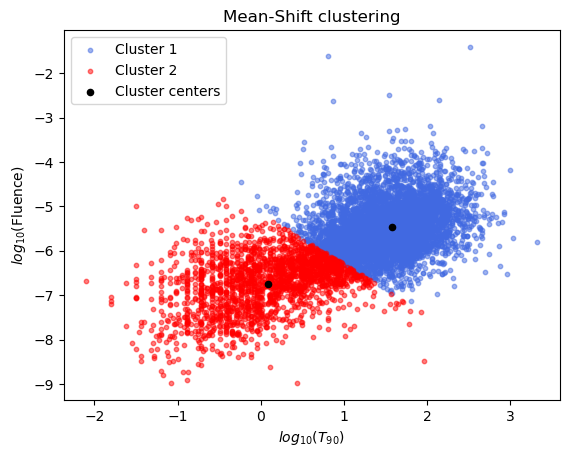

In [17]:
estimated_centers = kmean.cluster_centers_  #Without estimating the centers it doesn't work
ms = MeanShift(bandwidth=0.1, seeds = estimated_centers)  #Defining the Mean shift estimator object
ms.fit(Y)  #Fitting the data
centers_m = scaler.inverse_transform(ms.cluster_centers_)  #Computing the location of cluster centers
labels_m = ms.predict(Y)  #Predicting the labels for each of the points

#Plotting the results
for ii in range(2):
    plt.scatter(X[labels_m==ii,0], X[labels_m==ii,1], color=colors[ii] ,alpha=0.5, s=10, label='Cluster %i' %(ii+1))

plt.xlabel(r'$log_{10}(T_{90})$')
plt.ylabel(r'$log_{10}$(Fluence)')
plt.title('Mean-Shift clustering')
plt.scatter(centers_m[:,0],centers_m[:,1], color='black', s=20, label = 'Cluster centers')
plt.legend()
plt.show()

In [18]:
#Printing the values of the cluster centers
print('Cluster 1:')
print('T90 = %f s' %(10**(centers_m[0,0])))
print('Fluence = 10^(%f) erg/cm^2\n' %((centers_m[0,1])))
print('Cluster 2:')
print('T90 = %f s' %(10**(centers_m[1,0])))
print('Fluence = 10^(%f) erg/cm^2' %((centers_m[1,1])))

Cluster 1:
T90 = 37.398691 s
Fluence = 10^(-5.456648) erg/cm^2

Cluster 2:
T90 = 1.210932 s
Fluence = 10^(-6.758037) erg/cm^2


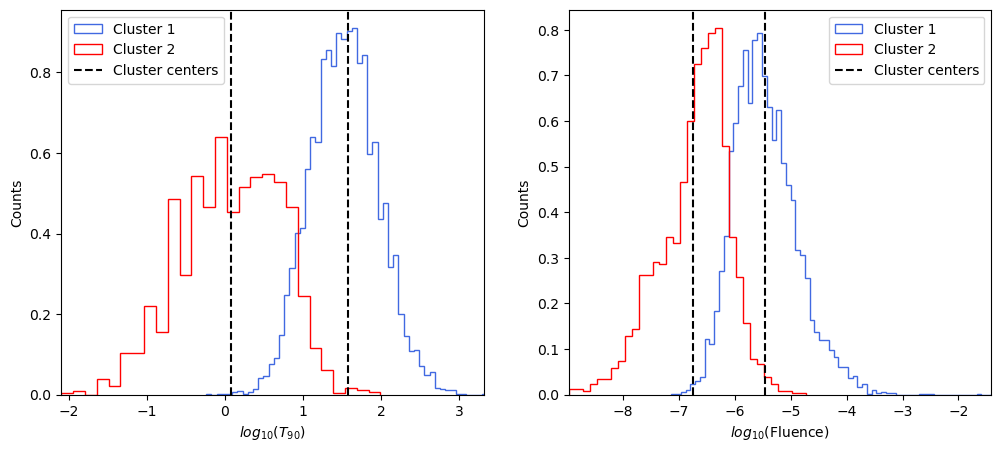

In [19]:
#Histogram of each singular clusters
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

fancyhist(X[labels_m==0,0], bins="freedman", density=True, ax=axs[0], ec='royalblue', histtype='step', label='Cluster 1')
fancyhist(X[labels_m==1,0], bins="freedman", density=True, ax=axs[0], ec='red', histtype='step', label='Cluster 2')
axs[0].axvline(centers_m[0,0], color = 'black', ls = '--', label = 'Cluster centers')
axs[0].axvline(centers_m[1,0], color = 'black', ls = '--')
axs[0].set_xlim(logT90.min(), logT90.max())
axs[0].set_xlabel(r'$log_{10}(T_{90})$')
axs[0].set_ylabel('Counts')
axs[0].legend(loc='upper left')

fancyhist(X[labels_m==0,1], bins="freedman", density=True, ax=axs[1], ec='royalblue', histtype='step', label='Cluster 1')
fancyhist(X[labels_m==1,1], bins="freedman", density=True, ax=axs[1], ec='red', histtype='step', label='Cluster 2')
axs[1].axvline(centers_m[0,1], color = 'black', ls = '--', label = 'Cluster centers')
axs[1].axvline(centers_m[1,1], color = 'black', ls = '--')
axs[1].set_xlim(logfluence.min(), logfluence.max())
axs[1].set_xlabel(r'$log_{10}$(Fluence)')
axs[1].set_ylabel('Counts')
axs[1].legend(loc='upper right')

plt.show()

In [20]:
#Printing the difference between the cluster centers of the two methods
print('Difference in the location of the cluster centers between K-Mean and Mean-shift:')
print('Cluster 1:')
print('T90 = %f s' %(10**(centers_m[0,0]) - 10**(centers_k[0,0])))
print('Fluence = %0.9f erg/cm^2\n' %(10**(centers_m[0,1]) - 10**(centers_k[0,1])))
print('Cluster 2:')
print('T90 = %f s' %(10**(centers_m[1,0]) - 10**(centers_k[1,0])))
print('Fluence = %0.9f erg/cm^2' %(10**(centers_k[1,1]) - 10**(centers_m[1,1])))

Difference in the location of the cluster centers between K-Mean and Mean-shift:
Cluster 1:
T90 = 3.622532 s
Fluence = -0.000000004 erg/cm^2

Cluster 2:
T90 = 0.017207 s
Fluence = 0.000000017 erg/cm^2


In [21]:
print('Confusion matrix between K-Means and Mean-Shift:')
print(confusion_matrix(labels_k, labels_m))

Confusion matrix between K-Means and Mean-Shift:
[[5299   12]
 [   0 2028]]


If we use the centres computed by K-means to estimate the centres in Mean-Shift, the two methods give similar results.

## Gaussian Mixture

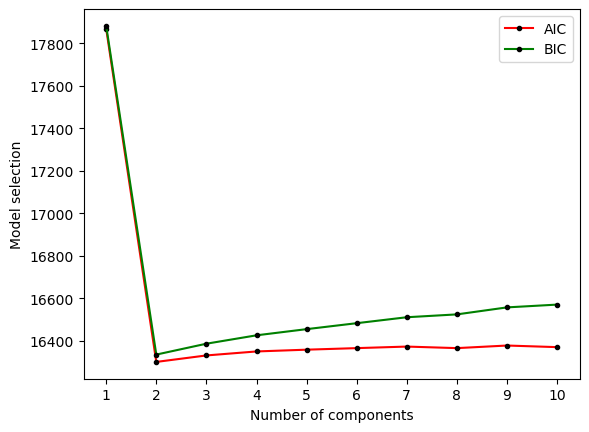

In [23]:
#Using AIC e BIC to find the number of components
N = np.arange(1, 11)
aic = np.zeros(10)
bic = np.zeros(10)
for i in N:
    gm = GaussianMixture(n_components=i, random_state=0, covariance_type='full').fit(logT90[:, None])
    aic[i-1] = gm.aic(logT90[:, None])
    bic[i-1] = gm.bic(logT90[:, None])

plt.plot(N, aic, color = 'red', marker = '.', markerfacecolor = 'black', markeredgecolor = 'black', label = 'AIC')
plt.plot(N, bic, color = 'green', marker = '.', markerfacecolor = 'black', markeredgecolor = 'black', label = 'BIC')
plt.xticks(N)
plt.xlabel('Number of components')
plt.ylabel('Model selection')
plt.legend()
plt.show()

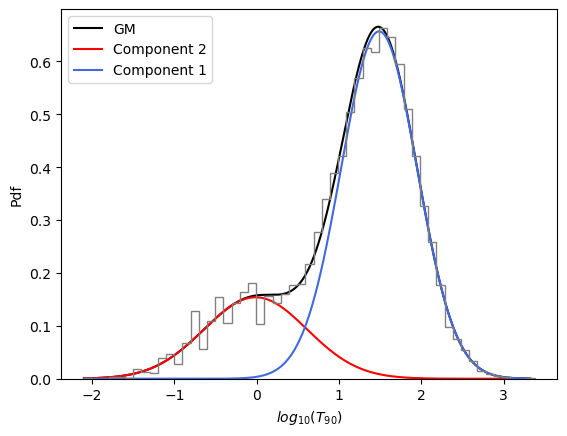

In [24]:
#Using GM to estimate the distribution of log(T90)
gm = GaussianMixture(n_components=2, random_state=42).fit(logT90[:, None])  #Defininf the GM estimator object and fitting the data
responsabilities = gm.predict_proba(Tgrid[:, None])  #Returns thedDensity of each Gaussian component for each sample
log_like = gm.score_samples(Tgrid[:, None])  
pdf = np.exp(log_like)  #Computing the global pdf
single_pdf = responsabilities*pdf[:, None]  #Computing the pdf of each component
means = gm.means_  #Computing the means of each component
labels_gm = gm.predict(logT90[:, None])  #Prediciting the labels of each sample

#Plotting the results
plt.plot(Tgrid, pdf, color = 'black', label = 'GM')
plt.plot(Tgrid, single_pdf[:, 0], color = 'red', label = 'Component 2')
plt.plot(Tgrid, single_pdf[:, 1], color = 'royalblue', label = 'Component 1')
fancyhist(logT90, bins="freedman", density=True, ec='grey', histtype='step')
plt.xlabel(r'$log_{10}(T_{90})$')
plt.ylabel('Pdf')
plt.legend(loc='upper left')
plt.show()

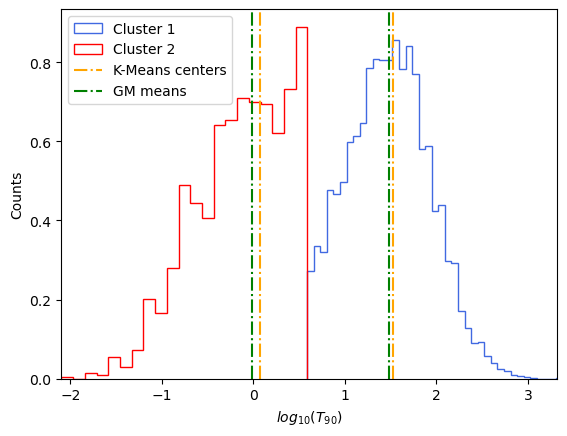

In [25]:
#Histogram of each singular clusters
fancyhist(X[labels_gm==1,0], bins="freedman", density=True, ec='royalblue', histtype='step', label='Cluster 1')
fancyhist(X[labels_gm==0,0], bins="freedman", density=True, ec='red', histtype='step', label='Cluster 2')
plt.axvline(centers_k[0,0], color = 'orange', ls = '-.', label = 'K-Means centers')
plt.axvline(centers_k[1,0], color = 'orange', ls = '-.')
plt.axvline(means[0], color = 'green', ls = '-.', label = 'GM means')
plt.axvline(means[1], color = 'green', ls = '-.')
plt.xlim(logT90.min(), logT90.max())
plt.xlabel(r'$log_{10}(T_{90})$')
plt.ylabel('Counts')
plt.legend(loc='upper left')

plt.show()

In [26]:
#Printing the values of the cluster centers
print('Cluster 1:')
print('T90 = %f s\n' %(10**(means[1,0])))
print('Cluster 2:')
print('T90 = %f s' %(10**(means[0,0])))

Cluster 1:
T90 = 30.724541 s

Cluster 2:
T90 = 0.970478 s


## GM vs KDE

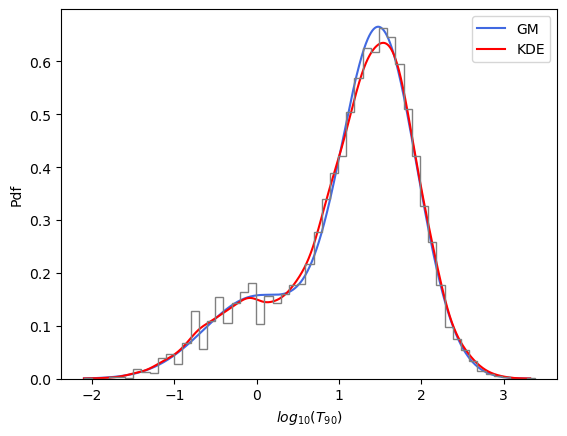

In [27]:
#Plotting the difference between GM and KDE
plt.plot(Tgrid, pdf, color = 'royalblue', label = 'GM')
plt.plot(Tgrid, pdf_T90, color = 'red', label = 'KDE') 
fancyhist(logT90, bins="freedman", density=True, ec='grey', histtype='step')
plt.xlabel(r'$log_{10}(T_{90})$')
plt.ylabel('Pdf')
plt.legend()
plt.show()

## 1-D Clustering

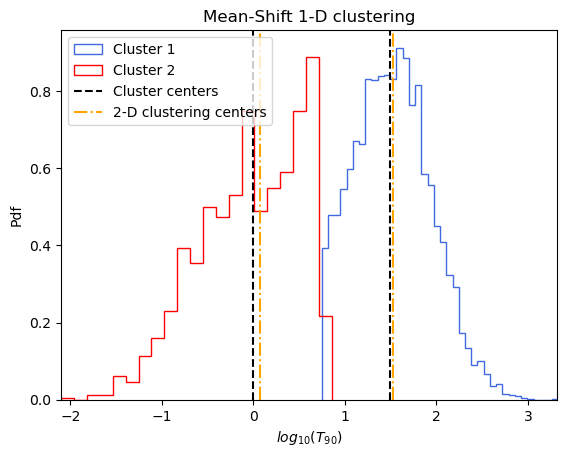

In [28]:
bandwidth = estimate_bandwidth(logT90[:, None])  
ms_T90 = MeanShift(bandwidth=bandwidth)  #Defining the Mean shift estimator object
ms_T90.fit(scaler.fit_transform(logT90[:, None]))  #Fitting the data
centers_T90 = scaler.inverse_transform(ms_T90.cluster_centers_)  #Computing the location of cluster centers
labels_T90 = ms_T90.predict(scaler.fit_transform(logT90[:, None]))  #Predicting the labels for each of the points

#Plotting the results
fancyhist(X[labels_T90==0,0], bins="freedman", density=True, ec='royalblue', histtype='step', label='Cluster 1')
fancyhist(X[labels_T90==1,0], bins="freedman", density=True, ec='red', histtype='step', label='Cluster 2')
plt.axvline(centers_T90[1][0], color = 'black', ls = '--', label = 'Cluster centers')
plt.axvline(centers_T90[0][0], color = 'black', ls = '--')
plt.axvline(centers_k[0,0], color = 'orange', ls = '-.', label = '2-D clustering centers')
plt.axvline(centers_k[1,0], color = 'orange', ls = '-.')
plt.xlim(logT90.min(), logT90.max())
plt.xlabel(r'$log_{10}(T_{90})$')
plt.ylabel('Pdf')
plt.title('Mean-Shift 1-D clustering')
plt.legend(loc='upper left')

plt.show()

In [29]:
#Printing the values of the cluster centers
print('Cluster 1:')
print('T90 = %f s\n' %(10**(centers_k[0,0])))
print('Cluster 2:')
print('T90 = %f s' %(10**(centers_k[1,0])))

Cluster 1:
T90 = 33.776159 s

Cluster 2:
T90 = 1.193725 s


#### Comparison between the models

In [30]:
print('Confusion matrix between 1-d clustering and GaussianMixture:')
print(confusion_matrix(1-labels_gm, labels_T90))

Confusion matrix between 1-d clustering and GaussianMixture:
[[5473  268]
 [   0 1598]]


In [31]:
print('Confusion matrix between 1-d and 2-D clustering:')
print(confusion_matrix(labels_m, labels_T90))

Confusion matrix between 1-d and 2-D clustering:
[[5149  150]
 [ 324 1716]]
